# Adversarial Reprogramming

We reprogram a pre-trained ImageNet classification model to perform fraud detection on transaction data

In [40]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import DenseNet161_Weights
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

import math

## Load the ImageNet dataset. 

ImageNet is an image database that spans 1,000 classes and contains 14,197,122 images. 

For adversarial reprogramming, we only need one host image. 5 images have been pre-loaded into `ImageNet_images.npy` file, which can be extracted directly as numpy array. The size of each ImageNet image is 3x224x224 

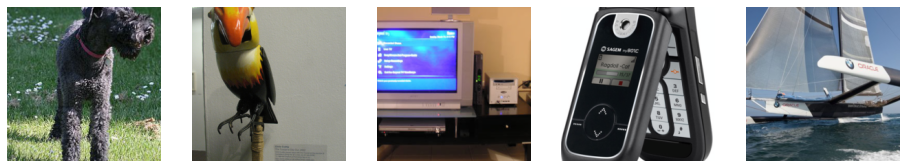

In [41]:
#Please place ImageNet_images.npy and your notebook/python file in the same directory; otherwise, change DATA_PATH 
DATA_PATH = ""
npy_path = os.path.join(DATA_PATH, "ImageNet_images.npy")

#Load 5 images from ImageNet
host_images = np.load(npy_path)
# print(host_images.shape)

# Plot the data
def plot_digits(instances, images_per_row=5):
    for i in range(len(instances)):
        idx = i % images_per_row
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = np.transpose(instances[i], (1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[idx].imshow(image)
        ax[idx].axis("off")

fig, ax = plt.subplots(1, 5, figsize=(16, 8))
plot_digits(host_images, images_per_row=5)
plt.show()

## Load the pretrained ImageNet classification neural network

The torchvision.models subpackage contains definitions of models for ImageNet image classification with pre-trained weights for every provided architecture. These pretrained models include ResNet, DenseNet, VGG, and so on.

In [42]:
#Here, densenet161 is loaded as pretrained model
#The pretrained model won't be updated during adversarial reprogramming
#So use the pre-trained weights and requires_grad for all layers is set as False
#pretrained_weights = DenseNet161_Weights.DEFAULT
pretrained_model = models.densenet161(pretrained=True)
pretrained_model.eval()
for param in pretrained_model.parameters():
    param.requires_grad = False

C:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Fraud Detection Model

#### Load the transaction dataset

38 features and the labels are: '1' is fraudulent and '0' is valid

In [43]:
#Please place transactions.csv and your notebook/python file in the same directory; otherwise, change DATA_PATH 
DATA_PATH = ""

def load_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "transactions.csv")
    return pd.read_csv(csv_path)

transactions = load_data()

#Divide the data frame into features and labels
labels = transactions["label"].copy() 
features = transactions.drop("label", axis=1)

features = features.astype(np.float32).to_numpy()
labels = labels.astype(np.int64).to_numpy()

#Choose a subset for model training
features_0 = features[labels == 0]
labels_0 = labels[labels == 0]
features_1 = features[labels == 1]
labels_1 = labels[labels == 1]

X = np.concatenate((features_0[:50], features_1[:50]), axis=0)
y = np.concatenate((labels_0[:50], labels_1[:50]), axis=0)

#Data splits for fraud detection (binary classification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80, 38)
(80,)
(20, 38)
(20,)


#### Train a logistic regression classification model from scratch for fraud detection

In [44]:
log_reg = LogisticRegression(solver="newton-cg", random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Before label flipping attack - Accuracy: %.4f, F1_score: %.4f" % (accuracy, f1))

Before label flipping attack - Accuracy: 0.6500, F1_score: 0.6491


## Adversarial Reprogramming for Fraud Detection

#### Reprogram image classification model to perform fraud detection task

This include input transformation to add transaction features and perturbation to an ImageNet image, and output transformation to map 1,000 ImageNet classes to 2 fraud detection classes (0, 1). Here, we use hard-coded mapping, which uses ImageNet class (0) to predict fraud detection class (0 - valid), and uses ImageNet class (1) to predict fraud detection class (1 - fraudulent)

#### Add transaction features to a host image

A image is randomly selected from the previously loaded ImageNet dataset as the host image. Based on this selected image, embed transaction features for each transaction to the host image to construct a new dataset that can be fed to the image classification model   

In [45]:
np.random.seed(42)

class InputTransformation(Dataset):
    def __init__(self, features, labels, host_image, mask, indices, feature_size, transform=None):
        self.features = features
        self.labels = labels
        self.host_image = host_image
        self.mask = mask
        self.indices = indices
        self.feature_size = feature_size
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        host_image = self.host_image.copy()
        host_image = host_image.reshape(3 * 224 * 224)
        host_image[self.indices] = features
        host_image = host_image.reshape((3, 224, 224))
        sample = {'image': host_image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label = np.array(label)
        return [torch.from_numpy(image).float(), torch.from_numpy(label).long()]

#Transaction feature size
feature_size = X_test.shape[1]
    
#Randomly choose an ImageNet image as the host image
#As only 5 ImageNet images have been loaded
#You can only set the index from 0-4
index = 0
host_image = host_images[index]

#After we add the transaction features into the host image
#We need to add perturbation to the host image as well
#To avoid the pixels that have been used to store transaction features from being perturbed
#Here a mask is generated to zero these pixels
mask = np.ones_like(host_image)
mask = mask.reshape(3 * 224 * 224)
#Embed the features into the pixels randomly selected from all the pixels
indices = np.random.choice(3 * 224 * 224, feature_size, replace=False)
mask[indices] = 0
mask = mask.reshape((3, 224, 224))

#Training dataset for adversarial reprogramming
ar_train_dataset = InputTransformation(features=X_train,
                               labels=y_train,
                               host_image=host_image,
                               mask=mask,
                               indices=indices,
                               feature_size=feature_size,
                               transform=transforms.Compose([
                                   ToTensor()
                               ]))

#Load datasets into DataLoader
ar_train_dataloader = DataLoader(ar_train_dataset, batch_size=4, shuffle=True)

#Test dataset for adversarial reprogramming
ar_test_dataset = InputTransformation(features=X_test,
                               labels=y_test,
                               host_image=host_image,
                               mask=mask,
                               indices=indices,
                               feature_size=feature_size,
                               transform=transforms.Compose([
                                   ToTensor()
                               ]))

#Load datasets into DataLoader
ar_test_dataloader = DataLoader(ar_test_dataset, batch_size=4, shuffle=False)

#### Build an adversarial reprogramming model

In [46]:
class AdversarialReprogrammingNet(nn.Module):
    def __init__(self, mask, pretrained_model):
        super(AdversarialReprogrammingNet, self).__init__()
        self.hard_coded_idx = [0, 1]
        self.mask = torch.FloatTensor(mask)
        self.perturbation = Parameter(torch.FloatTensor(3, 224, 224), requires_grad=True)
        self.reset_parameter()
        
        self.pretrained_model = pretrained_model
    
    def reset_parameter(self):
        stdv = 1. / math.sqrt(self.perturbation.size(1))
        self.perturbation.data.uniform_(-stdv, stdv)
    
    def forward(self, x):
        x = x + self.perturbation * self.mask
        x = self.pretrained_model(x)
        y = x[:, self.hard_coded_idx]
        return y

#### Set up hyperparameters and training and test functions

In [53]:
torch.manual_seed(42)
epochs = 5
learning_rate = 0.001
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

adversarial_reprogramming_model = AdversarialReprogrammingNet(mask, pretrained_model)
parameter_to_update = []
for p in adversarial_reprogramming_model.parameters():
    if p.requires_grad:
        parameter_to_update.append(p)
        break
adversarial_reprogramming_optimizer = optim.Adam(parameter_to_update, lr=learning_rate, weight_decay=weight_decay)

#Pre-define the training function
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))
 

#Pre-define the test function
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))

#### Train the adversarial reprogramming model

In [54]:
#Train the adversarial reprogramming model
for epoch in range(1, epochs + 1):
    train(epoch, adversarial_reprogramming_model, ar_train_dataloader, adversarial_reprogramming_optimizer, lossfunction)

epoch (1): Train accuracy: 0.6125, loss: 0.173
epoch (2): Train accuracy: 0.7250, loss: 0.161
epoch (3): Train accuracy: 0.7250, loss: 0.152
epoch (4): Train accuracy: 0.7750, loss: 0.135
epoch (5): Train accuracy: 0.7875, loss: 0.143


#### Test the adversarial reprogramming model for fraud detection

In [55]:
#Test the model
test(adversarial_reprogramming_model, ar_test_dataloader)

Test accuracy: 0.7500, macro f1_score: 0.6865


#### <font color='red'>When training a fraud detection model from scratch using logistic regression on a small dataset (80 training samples), the accuracy is 0.6500; when using adversarial reprogramming to reprogram ImageNet classification model for fraud detection, the accuracy can increase to 0.7500 (note that, we only perform 5 epochs here without any hyperparameter adjustments)</font>